In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
from collections import defaultdict
import pathlib
import seaborn as sns
from functools import partial
import statsmodels

from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import conditional_probability, joint_probability, roll_pad
from causal_optoconnectics.tools import compute_trials_multi, decompress_events
from causal_optoconnectics.core import Connectivity

%matplotlib inline

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_3/sparsity_00/')
# data_path = pathlib.Path('/home/users/bjornmik/causal-optoconnectics/scripts/datasets/confounding_simulation_100_5_6.npz')
# data_path = pathlib.Path('/mnt/Dropbox (UiO)/Projects/causal-optoconnectics/scripts/')
# data_path = pathlib.Path('/home/users/bjornmik/causal-optoconnectics/scripts/datasets/sparsity_08.npz')

def load(path, multi=True):
    if multi:
        data = np.load(path / 'rank_0.npz', allow_pickle=True)   
        data = {k: data[k][()] for k in data.keys()}
        data['data'] = [np.load(fn, allow_pickle=True)['data'][()] for fn in path.glob('*.npz')]
        data['all_params'] = [np.load(fn, allow_pickle=True)['params'][()] for fn in path.glob('*.npz')]
        data['all_W_0'] = [np.load(fn, allow_pickle=True)['W_0'][()] for fn in path.glob('*.npz')]
        data['all_W'] = [np.load(fn, allow_pickle=True)['W'][()] for fn in path.glob('*.npz')]

        assert(not any([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['data'], data['data'][1:])]))
        assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W_0'], data['all_W_0'][1:])]))
        assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W'], data['all_W'][1:])]))
    else:
#         npz = [f for f in path.glob('*.npz')]
#         assert len(npz) == 1
#         data = np.load(npz[0], allow_pickle=True)
        data = np.load(path, allow_pickle=True)
        data = {k: data[k][()] for k in data.keys()}
    return data

In [4]:
data = load(data_path, multi=True)

In [5]:
W_0 = data['W_0']
W = data['W']
stim_index = len(W_0)
params = data['params']
n_time_step = params['n_time_step']
n_neurons = params['n_neurons']
dt = params['dt']

In [6]:
data['params']

{'const': 5,
 'n_neurons': 50,
 'n_stim': 5,
 'dt': 0.001,
 'ref_scale': 10,
 'abs_ref_scale': 3,
 'spike_scale': 5,
 'abs_ref_strength': -100,
 'rel_ref_strength': -30,
 'stim_scale': 2,
 'stim_strength': 6,
 'stim_period': 50,
 'stim_isi_min': 10,
 'stim_isi_max': 200,
 'drive_scale': 10,
 'drive_strength': -100,
 'drive_period': 100,
 'alpha': 0.2,
 'glorot_normal': {'mu': 0, 'sigma': 7},
 'n_time_step': 1000000,
 'seed': 12345,
 'sparsity': 0}

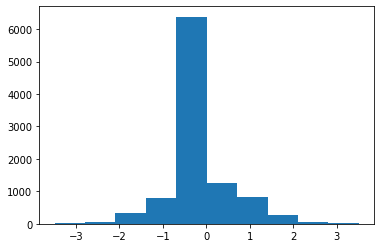

In [7]:
plt.hist(W_0.ravel());

In [8]:
x = decompress_events(data['data'][0], len(W), n_time_step)

In [9]:
times = np.arange(n_time_step) * dt

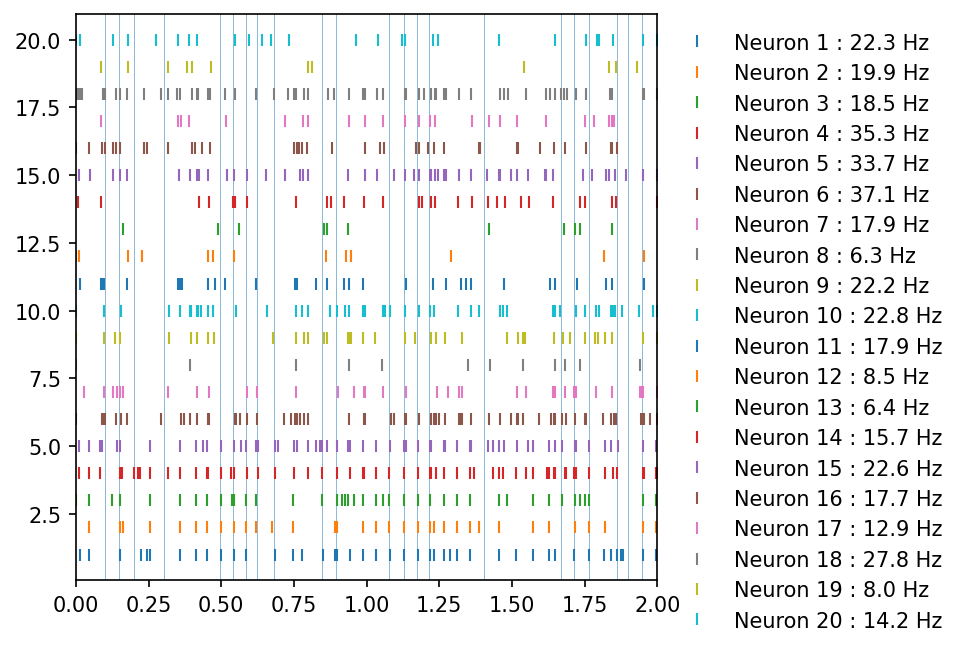

In [10]:
plt.figure(figsize=(5,5), dpi=150)
xlim = min(2, times[-1])
plot_x = x.copy()
plot_x[plot_x==0.0] = np.nan
for i in range(min(20,len(x))):
    plt.plot(times,plot_x[i]*(i+1), marker='|', ls='none', label=f'Neuron {i+1} : {sum(x[i])/times[-1]:.1f} Hz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.xlim(0, xlim)
stim_times = times[x[stim_index].astype(bool)]
for stim_time in stim_times[stim_times<xlim]:
    plt.axvspan(stim_time, stim_time+params['stim_scale']*params['dt'], alpha=0.5)

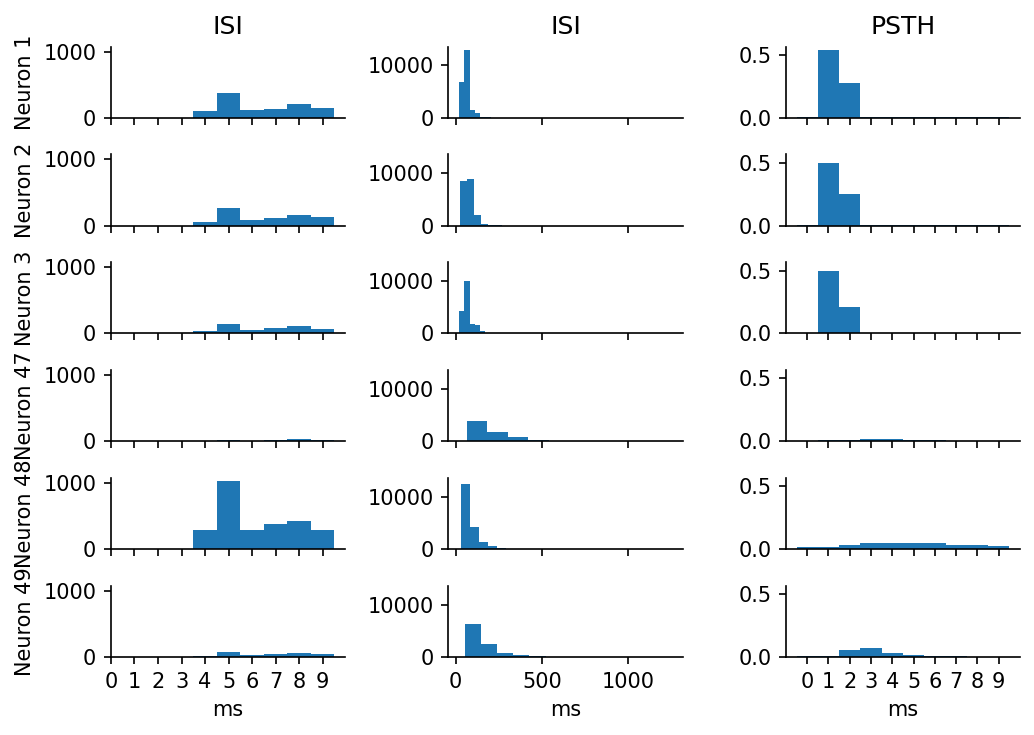

In [11]:
fig, axs = plt.subplots(min(6, len(W_0)), 3, figsize=(7,5), dpi=150, sharex='col', sharey='col')
n_step = 10
stim = x[stim_index].astype(int)

neuron_idx = [*data['excitatory_neuron_idx'][:3], *data['excitatory_neuron_idx'][-4:-1]]

for i, ax in enumerate(axs): 
    neuron = x[neuron_idx[i]]
    t1 = times[neuron.astype(bool)]
    diff = np.diff(t1) * 1000 # ms
    bins = np.arange(0, 0.01, dt) * 1000
    ax[0].hist(diff, bins=bins, align='right')
    ax[0].set_xticks(bins)
    ax[1].hist(diff, align='right')
    psth_bins = np.arange(n_step)
    psth = [(neuron*roll_pad(stim, j)).sum() / stim.sum() for j in psth_bins]
    ax[2].bar(psth_bins, psth, width=1)
    ax[2].set_xticks(psth_bins)
    sns.despine()

for ax in axs[-1]:
    ax.set_xlabel('ms')
    
for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel(f'Neuron {neuron_idx[i]+1}')
    
for ax, title in zip(axs[0], ['ISI', 'ISI', 'PSTH']):
    ax.set_title(title)
    
plt.tight_layout()

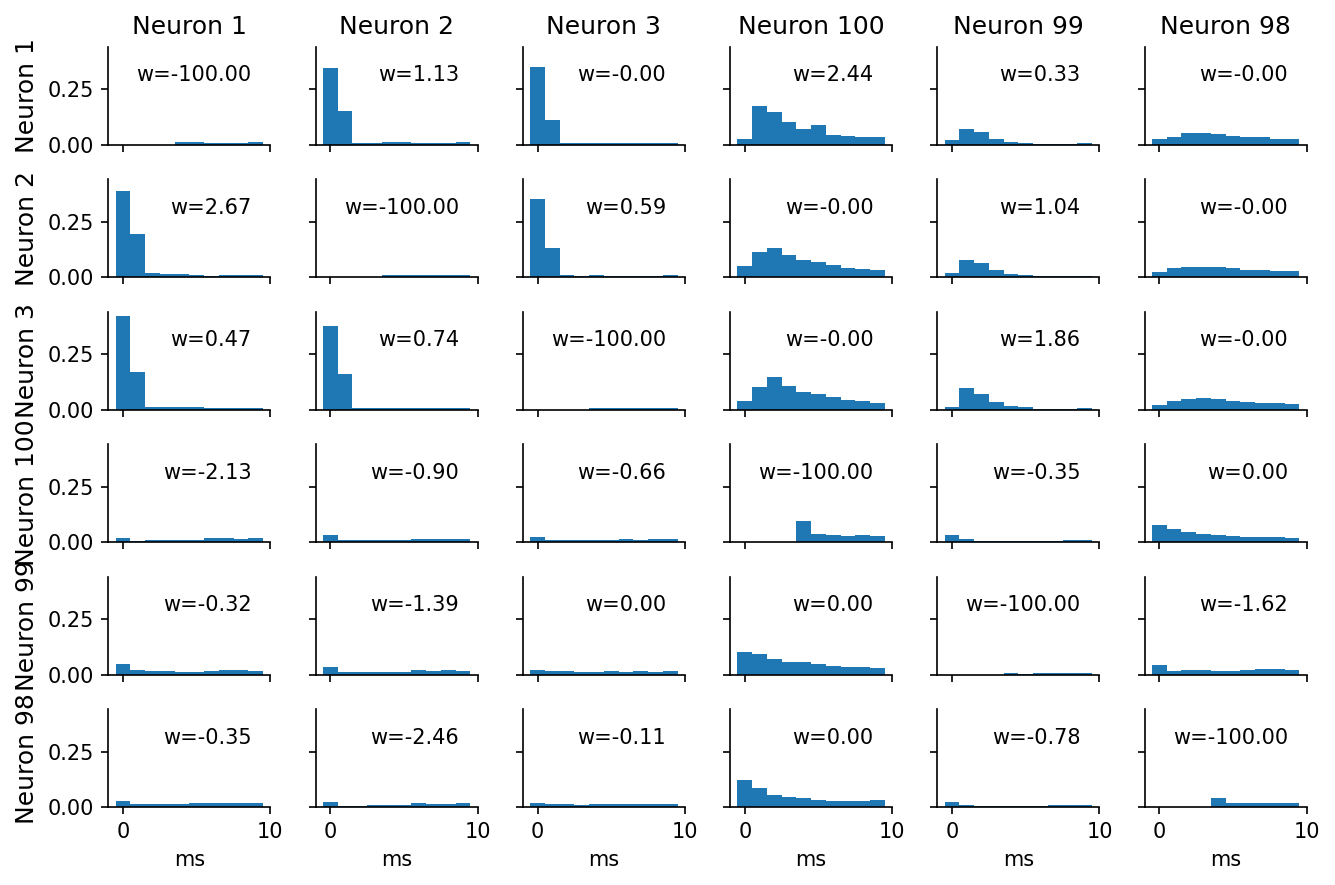

In [12]:
fig, axs = plt.subplots(min(6, len(W_0)), min(6, len(W_0)), figsize=(9,6), dpi=150, sharex=True, sharey=True)
n_step = 10
neuron_idx = [range(len(x))[i] for i in [0, 1, 2, -3, -4, -5]]
for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        neuron_i = x[neuron_idx[i]]
        neuron_j = x[neuron_idx[j]]
        skip = 1 if i==j else 0 # remove zero lag in neuron autocorrelation
        lags = np.arange(skip, n_step)
        shift = [(neuron_j * roll_pad(neuron_i, jj)).sum() / roll_pad(neuron_i, jj).sum() for jj in lags]
#         shift = [(neuron_j * np.roll(neuron_i, jj)).sum() for jj in lags]
        ax.bar(lags, shift, width=1, label=f'w={W[neuron_idx[i],neuron_idx[j],0]:.2f}')
    
        ax.legend(frameon=False, handlelength=0)
        sns.despine()
        
for ax in axs[-1]:
    ax.set_xlabel('ms')
    
for i, ax in enumerate(axs.T[0]):
    ax.set_ylabel(f'Neuron {neuron_idx[i]+1}', fontsize=plt.rcParams['axes.titlesize'])
    
for i, ax in enumerate(axs[0]):
    ax.set_title(f'Neuron {neuron_idx[i]+1}')
    
plt.tight_layout()

# Make trials

In [13]:
trials = compute_trials_multi(data['data'], n_neurons, stim_index)

In [14]:
trials[0].shape

(2240448, 20)

# Process results

In [15]:
x_i, x_j = 11, 13
y_i, y_j = 12, 19
z_i, z_j = 7, 10
    
    
def process(pair, n_trials=None):
    i, j = [int(a) for a in pair.split('_')]
    pre, post = trials[i], trials[j]
    
    n_trials = len(pre) if n_trials is None else n_trials
    
    conn = Connectivity(pre[:n_trials], post[:n_trials], x_i, x_j, y_i, y_j, z_i, z_j)
    
    result ={
        'source': i,
        'target': j,
        'pair': pair,
        'beta_iv': conn.beta_iv, 
        'beta': conn.beta,
        'beta_iv_did': conn.beta_iv_did, 
        'beta_did': conn.beta_did, 
        'hit_rate': conn.hit_rate,
        'weight': W[i, j, 0],
        'source_stim': W[stim_index, i, 0] > 0,
        'source_stim_strength': W[stim_index, i, 0],
        'target_stim': W[stim_index, j, 0] > 0,
    }
    return result


def compute_time_dependence(i, j, step=10000):
    pair = f'{i}_{j}'
    pre, post = trials[i], trials[j]
    results = []
    start = 0
    for stop in tqdm(range(step, len(pre) + step, step)):
        results.append(process(pair, stop))
    return results


def multi_process(n_trials=None, pairs=None):
    import multiprocessing
    from functools import partial
    
    if pairs is None:
        pairs = [f'{i}_{j}' for i in range(n_neurons) for j in range(n_neurons) if i != j]
    
    with multiprocessing.Pool() as p:
        results = p.map(partial(process, n_trials=n_trials), pairs)
        
    return results

In [16]:
results = multi_process()
# results = list(map(partial(process, trials=trials, W=W, stim_index=stim_index, params=params), tqdm([f'{i}_{j}' for i in range(len(W_0)) for j in range(len(W_0)) if i != j])))

In [17]:
results = pd.DataFrame(results)

In [18]:
results.iloc[:10].T

,0,1,2,3,4,5,6,7,8,9
source,0,0,0,0,0,0,0,0,0,0
target,1,2,3,4,5,6,7,8,9,10
pair,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10
beta_iv,0.098401,0.039475,0.0415,0.055117,0.024852,0.029444,0.000467,0.038792,0.070632,0.016111
beta,0.120637,0.12106,0.204425,0.218986,0.376161,0.216261,0.015395,0.264186,0.325716,0.212423
beta_iv_did,0.178279,0.049311,0.065544,0.046802,0.000173,0.016336,-0.003026,0.032903,0.074807,0.019124
beta_did,0.131724,0.131532,0.246844,0.26261,0.428163,0.25133,0.031019,0.293892,0.369287,0.248873
hit_rate,0.818743,0.818743,0.818743,0.818743,0.818743,0.818743,0.818743,0.818743,0.818743,0.818743
weight,1.13198,-0.0,-0.0,0.17759,-0.0,-0.0,-0.0,0.777913,0.336515,0.239288
source_stim,True,True,True,True,True,True,True,True,True,True


In [19]:
sample = results.query('source_stim and not target_stim and weight > 0')
# sample = results.query('source_stim and not target_stim')

In [20]:
sample

,source,target,pair,beta_iv,beta,beta_iv_did,beta_did,hit_rate,weight,source_stim,source_stim_strength,target_stim
7,0,8,0_8,0.038792,0.264186,0.032903,0.293892,0.818743,0.777913,True,6.0,False
8,0,9,0_9,0.070632,0.325716,0.074807,0.369287,0.818743,0.336515,True,6.0,False
9,0,10,0_10,0.016111,0.212423,0.019124,0.248873,0.818743,0.239288,True,6.0,False
10,0,11,0_11,0.053245,0.152335,0.094868,0.160995,0.818743,2.192817,True,6.0,False
13,0,14,0_14,0.072654,0.360750,0.066765,0.393529,0.818743,0.198532,True,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
238,4,43,4_43,0.016398,0.153988,0.109881,0.165063,0.816402,0.330342,True,6.0,False
240,4,45,4_45,0.185407,0.321367,0.254105,0.330742,0.816402,1.593480,True,6.0,False
241,4,46,4_46,0.026883,0.054761,0.058295,0.060117,0.816402,0.787295,True,6.0,False
242,4,47,4_47,0.010126,0.180877,0.073941,0.191475,0.816402,0.290949,True,6.0,False


# Regression analysis

In [21]:
# ill conditions, eigenspectrum, inverse problem, condition number, causal analysis is inverse
# if condition nr is one, OLS should work, condition number larger than one is confounded, too much and IV does not help
# the dial for conditino nr, high baseline weak interaction OLS good, same baseline stronger interactions larger condition nr IV good, keep going high condiiton nr IV does not work
# amount of data prop with cond nr, 10 times larger cond nr 10 times more data.

# make cond prob plots on 50 neuron case to konrad

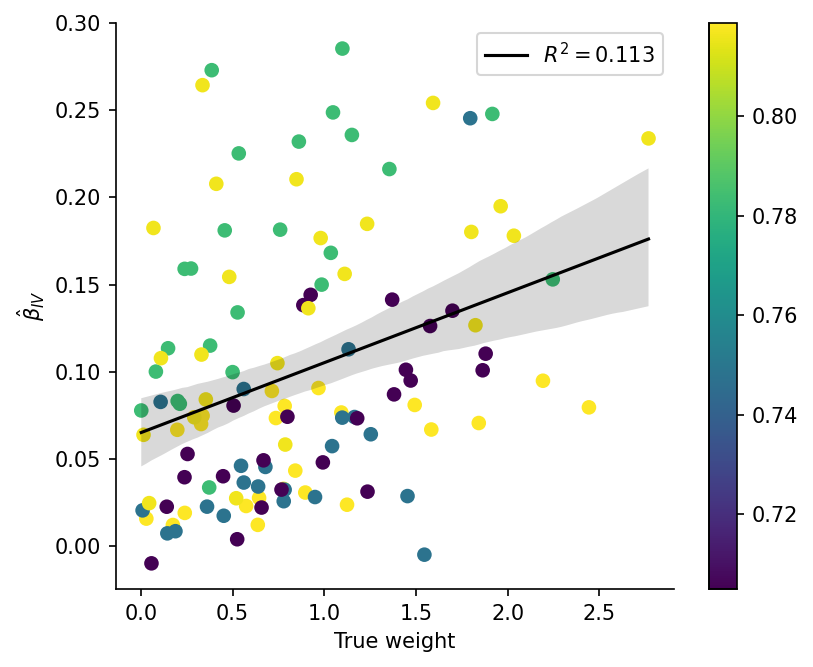

In [22]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'weight', 'beta_iv_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')
sns.despine()

# ylim = ax.get_ylim()
# ylim = [ylim[0], 0.065]
# ax.set_ylim(ylim)

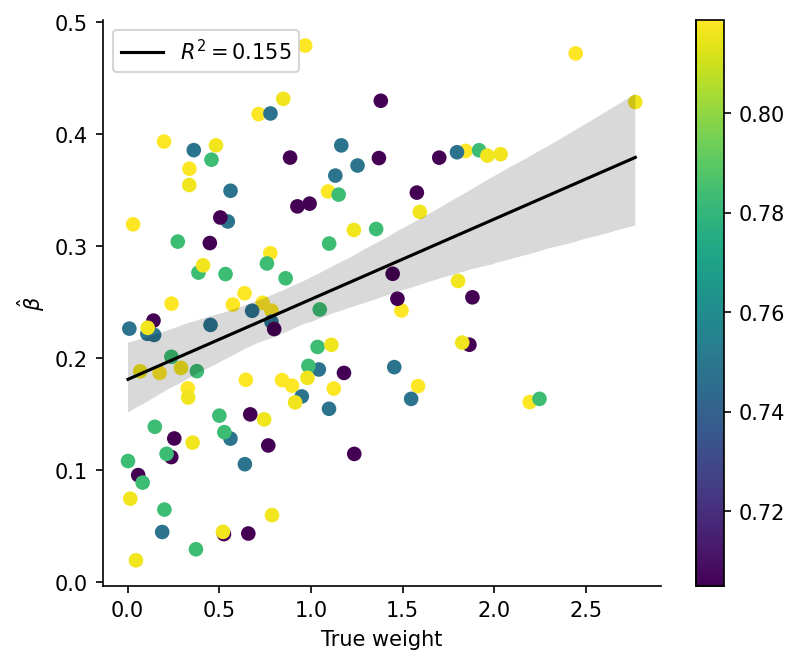

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'weight', 'beta_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')
sns.despine()

# ax.set_ylim(ylim)

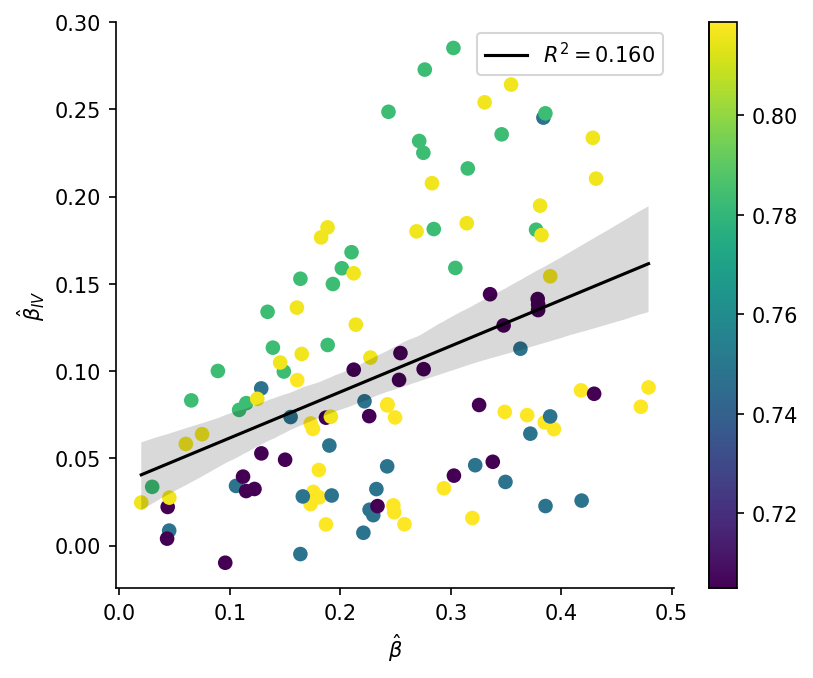

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6,5), dpi=150)
model = regplot(
    'beta_did', 'beta_iv_did', data=sample, 
    scatter_color=sample['hit_rate'], colorbar=True, ax=ax)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}$')
plt.ylabel(r'$\hat{\beta}_{IV}$')
sns.despine()

# False positives

In [25]:
sample_zero = results.query('source_stim and not target_stim and weight < 0.1 and weight >= 0')
sample_zero

,source,target,pair,beta_iv,beta,beta_iv_did,beta_did,hit_rate,weight,source_stim,source_stim_strength,target_stim
4,0,5,0_5,0.024852,0.376161,0.000173,0.428163,0.818743,-0.0,True,6.0,False
5,0,6,0_6,0.029444,0.216261,0.016336,0.251330,0.818743,-0.0,True,6.0,False
6,0,7,0_7,0.000467,0.015395,-0.003026,0.031019,0.818743,-0.0,True,6.0,False
11,0,12,0_12,0.012139,0.027872,0.016743,0.039763,0.818743,-0.0,True,6.0,False
12,0,13,0_13,0.019955,0.143933,0.038432,0.174482,0.818743,-0.0,True,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
233,4,38,4_38,0.081791,0.236709,0.233799,0.258154,0.816402,-0.0,True,6.0,False
236,4,41,4_41,0.015387,0.021937,0.042588,0.026248,0.816402,-0.0,True,6.0,False
237,4,42,4_42,0.050320,0.062660,0.099090,0.068360,0.816402,-0.0,True,6.0,False
239,4,44,4_44,0.057846,0.258215,0.124360,0.272351,0.816402,-0.0,True,6.0,False


([<matplotlib.axis.XTick at 0x7fe979320280>,
 [Text(1, 0, '$\\beta_{IV}$'), Text(2, 0, '$\\beta$')])

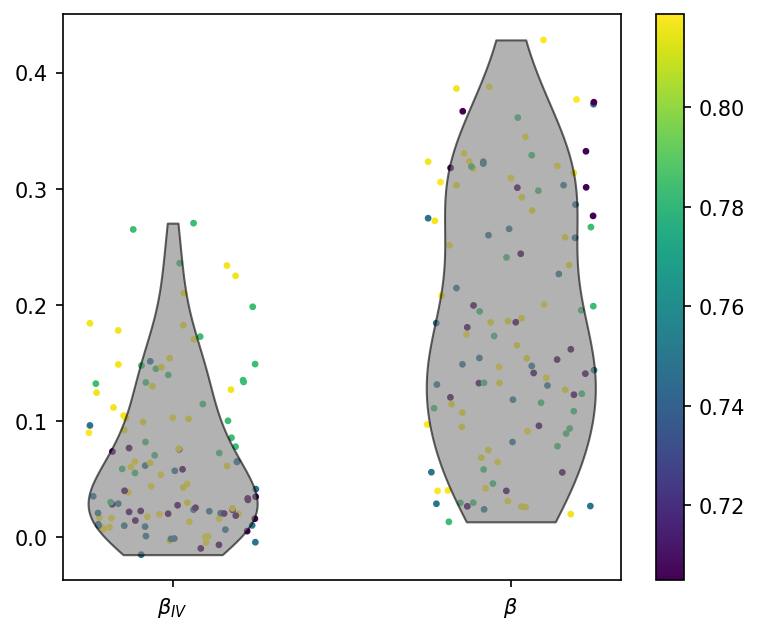

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=150)
pos = np.random.uniform(.25,.75, size=len(sample_zero))
ax.scatter(pos + .5, sample_zero.beta_iv_did, c=sample_zero.hit_rate, s=5)
sc = ax.scatter(pos + 1.5, sample_zero.beta_did, c=sample_zero.hit_rate, s=5)

cb = plt.colorbar(mappable=sc, ax=ax)
cb.ax.yaxis.set_ticks_position('right')

violins = plt.violinplot(sample_zero.loc[:, ['beta_iv_did', 'beta_did']], showextrema=False, bw_method=0.5)
for pc in violins['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])

# Error analysis

In [33]:
sample_error = results.query('source_stim and not target_stim')

In [27]:
from scipy.linalg import norm
from scipy.optimize import minimize_scalar

def error(a, df, key):
    return df['weight'] - a * df[key]

def error_norm(a, df, key):
    return norm(error(a, df, key))

def min_error(df, key):
    return minimize_scalar(error_norm, args=(df, key))

In [28]:
err_res_beta_iv = min_error(sample_error, 'beta_iv_did')
err_res_beta = min_error(sample_error, 'beta_did')

In [35]:
sample_error.loc[:,'error_beta_iv'] = error(err_res_beta_iv.x, sample_error, 'beta_iv_did')
sample_error.loc[:,'error_beta'] = error(err_res_beta.x, sample_error, 'beta_did')

([<matplotlib.axis.XTick at 0x7fe917b42730>,
 [Text(1, 0, '$\\beta_{IV}$'), Text(2, 0, '$\\beta$')])

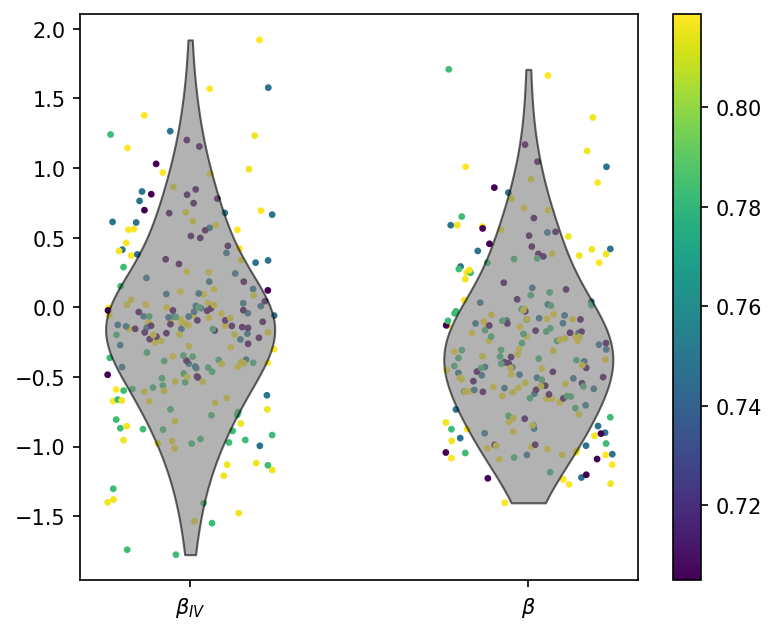

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=150)
pos = np.random.uniform(.25,.75, size=len(sample_error))
ax.scatter(pos + .5, sample_error.error_beta_iv, c=sample_error.hit_rate, s=5)
sc = ax.scatter(pos + 1.5, sample_error.error_beta, c=sample_error.hit_rate, s=5)

cb = plt.colorbar(mappable=sc, ax=ax)
cb.ax.yaxis.set_ticks_position('right')

violins = plt.violinplot(sample_error.loc[:, ['error_beta_iv', 'error_beta']], showextrema=False, bw_method=0.5)
for pc in violins['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks([1, 2], [r'$\beta_{IV}$', r'$\beta$'])

In [36]:
err_beta = min_error(sample, 'beta_did').fun
err_beta_iv = min_error(sample, 'beta_iv_did').fun

err_beta_zero = error_norm(1, sample_zero, 'beta_did')
err_beta_iv_zero = error_norm(1, sample_zero, 'beta_iv_did')

In [37]:
print(err_beta, err_beta_iv, err_beta_zero, err_beta_iv_zero)

6.167280066501074 7.1331386398329215 2.3171619172286593 1.0252258069021094


# Error convergence

In [ ]:
results_step = []
results_step_zero = []
start = 0
step = 10000
steps = np.arange(step, len(trials[0]) + step, step).astype(int)
for stop in tqdm(steps):
    if stop < 1e5:
        results_step.append(pd.DataFrame([process(pair, stop) for pair in sample.pair.values.tolist()]))
        results_step_zero.append(pd.DataFrame([process(pair, stop) for pair in sample_zero.pair.values.tolist()]))
    else:
        results_step.append(pd.DataFrame(multi_process(stop, sample.pair.values.tolist())))
        results_step_zero.append(pd.DataFrame(multi_process(stop, sample_zero.pair.values.tolist())))

  0%|          | 0/224 [00:00<?, ?it/s]

In [ ]:
errors = defaultdict(list)
for df in results_step:
    errors['beta'].append(min_error(df, 'beta_did').fun)
    errors['beta_iv'].append(min_error(df, 'beta_iv_did').fun)

In [ ]:
for df in results_step_zero:
    errors['beta_zero'].append(min_error(df, 'beta_did').fun)
    errors['beta_iv_zero'].append(min_error(df, 'beta_iv_did').fun)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(steps, errors['beta'], label=r'$\hat{\beta}$')
ax.plot(steps, errors['beta_iv'], label=r'$\hat{\beta}_{IV}$')
plt.legend(frameon=False)
ax.set_xscale('log')
sns.despine()
ax.set_xlabel('Trials')
ax.set_ylabel(r'$\mathrm{error}(\beta)$')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
ax.plot(steps, errors['beta_zero'], label=r'$\hat{\beta}$')
ax.plot(steps, errors['beta_iv_zero'], label=r'$\hat{\beta}_{IV}$')
plt.legend(frameon=False)
ax.set_xscale('log')
sns.despine()
ax.set_xlabel('Trials')
ax.set_ylabel(r'$\mathrm{error}(\beta)$')

# Graph analysis

In [105]:
import networkx as nx

In [106]:
g = nx.DiGraph()

In [107]:
# g.add_nodes_from(np.unique(results.source.values.tolist() + results.target.values.tolist()))

In [108]:
g.add_weighted_edges_from(results.apply(lambda x: (x.source, x.target, x.weight), axis=1).values.tolist())

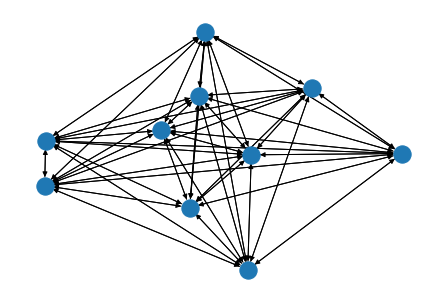

In [109]:
nx.draw(g)

In [110]:
A,C

(2, 19)

In [117]:
paths = list(nx.all_simple_edge_paths(g, A, C, cutoff=2))
print(list(paths)[0])

[(2, 0), (0, 19)]


In [122]:
np.sum([np.sum(g.get_edge_data(*e)['weight']) for p in paths for e in p])

12.0175851058479

# Plot all conditional probabilities

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

fig, axs = plt.subplots(117, 4, figsize=(15,350), dpi=150, sharex=True, sharey=True)
axs = axs.ravel()
for ii, (_, row) in enumerate(sample.iloc[:len(axs)].sort_values('weight').iterrows()):
    ax = axs[ii]
    A, C = row.loc[['source', 'target']].values.T
    cond_A_C = conditional_probability(trials[A], trials[C])
    probplot(cond_A_C, 0, ax=ax, colorbar=False)#, norm=colors.LogNorm(vmin=0.00001, vmax=joints[k].max()))
    ax.set_title(f'{row.pair} {row.weight:.3f}')
    ax.axvline(0, color='gray', lw=0.5, alpha=0.5)
    ax.axhline(0, color='gray', lw=0.5, alpha=0.5)
#     if ii > 10:
#         break
fig.savefig('conditional_probabilities.pdf', bbox_inches='tight')

# Inspect single pair

In [ ]:
# from utils import conditional_probability, probplot, joint_probability

In [ ]:
# sorted_df = sample.sort_values('weight', ascending=False)
sorted_df = sample.sort_values(['error_beta_iv'], ascending=False)
AC_row = sorted_df.iloc[0]
A, C = AC_row.loc[['source', 'target']].values.T

# A,C = 3, 46
sorted_df

In [ ]:
A,C

In [ ]:
tdep = pd.DataFrame(compute_time_dependence(A, C))

In [ ]:
plt.figure(figsize=(5,5), dpi=150)
# plt.plot(tdep.y_response)
# plt.plot(tdep.y_refractory)
# plt.plot(tdep.y_nospike)
# plt.plot(tdep.y0_response)
# plt.plot(tdep.y0_refractory)
# plt.plot(tdep.y0_nospike)
plt.plot(tdep.beta_did*err_res_beta.x, label=r'$\hat{\beta}$')
plt.plot(tdep.beta_iv_did*err_res_beta_iv.x, label=r'$\hat{\beta}_{IV}$')
plt.plot(tdep.weight, label='weight')
plt.plot([199,199], [tdep.weight.values[0] - AC_row.error_beta, tdep.weight.values[0]], color='C0', lw=0.5, ls='--')
plt.plot([200,200], [tdep.weight.values[0] - AC_row.error_beta_iv, tdep.weight.values[0]], color='C1', lw=0.5, ls='--')
plt.legend()

In [ ]:
def plot_response(i, j):
    psth_time = np.arange(-10,10)
    pre, post = trials[i], trials[j]
    n_trials = len(pre)
    fig, ax = plt.subplots(2,2, figsize=(8,6), dpi=150, sharey=True)
    ax = ax.ravel()
    ax[0].step(psth_time, pre.sum(0) / n_trials, where='post', label='pre')
    ax[0].step(psth_time, post.sum(0) / n_trials, where='post', label='post')
    ax[0].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[0].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[0].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[0].set_xticks(psth_time)
    ax[0].set_xticklabels(psth_time,rotation=45)
    ax[0].legend(frameon=False)
    
    x = pre[:,x_i:x_j].sum(1).astype(bool)
    y = post[:,y_i:y_j].sum(1).astype(bool)
    z = pre[:,z_i:z_j].sum(1).astype(bool)
    
    ax[1].step(psth_time, pre[x==1].sum(0) / n_trials, label='pre respond', where='post')
    ax[1].step(psth_time, pre[z==1].sum(0) / n_trials, label='pre refractory', where='post')
    ax[1].step(psth_time, post[x==1].sum(0) / n_trials, label='post respond', where='post')
    ax[1].step(psth_time, post[z==1].sum(0) / n_trials, label='post refractory', where='post')
    ax[1].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[1].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[1].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[1].set_xticklabels(psth_time,rotation=45)
    ax[1].legend(frameon=False)
    ax[1].set_xticks(psth_time)
    ax[1].set_xticklabels(psth_time,rotation=45)
    
    ax[2].step(psth_time, pre[x==1].sum(0) / n_trials, label='pre respond', where='post')
    ax[2].step(psth_time, pre[x==0].sum(0) / n_trials, label='pre nospike', where='post')
    ax[2].step(psth_time, post[x==1].sum(0) / n_trials, label='post respond', where='post')
    ax[2].step(psth_time, post[x==0].sum(0) / n_trials, label='post nospike', where='post')
    ax[2].axvspan(psth_time[x_i], psth_time[x_j], alpha=0.2, color='C0')
    ax[2].axvspan(psth_time[y_i], psth_time[y_j], alpha=0.2, color='C1')
    ax[2].axvspan(psth_time[z_i], psth_time[z_j], alpha=0.2, color='red')
    ax[2].set_xticklabels(psth_time,rotation=45)
    ax[2].legend(frameon=False)
    ax[2].set_xticks(psth_time)
    ax[2].set_xticklabels(psth_time,rotation=45)
#     ax[2].set_title()
    
    ax[3].remove()
    
    sns.despine()
    

In [ ]:
plot_response(A, C)

In [ ]:
process(f'{A}_{C}')

In [ ]:
N = 10

In [ ]:
cond_A_A = conditional_probability(trials[A][:,:N], trials[A][:,N:])

In [ ]:
probplot(cond_A_A, 0, *[-10,0,0,10])

In [ ]:
cond_A_C = conditional_probability(trials[A], trials[C])

In [ ]:
probplot(cond_A_C, 0, grid='zero')

In [ ]:
plt.figure()
im = plt.imshow(cond_A_C[12:14,11:14], origin='lower')
plt.colorbar(im)

plt.figure()
im = plt.imshow(cond_A_C[12:14,7:10], origin='lower')
plt.colorbar(im)

In [ ]:
cond_A_C[12:14,11:14].sum() - cond_A_C[12:14,7:10].sum()